# Demo File
This demo tests the functionality of the EchoStateNetwork with different time series

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ESN import EchoStateNetwork
from ESN import MackeyGlassGenerator
from ESN import GinfActivator

ginf_activator = GinfActivator(V_min=-2, V_max=2, resolution=200, offset=True)

def mse(test, predictions):
    return np.mean((predictions[100:] - test[100:]) ** 2)

# Steady State Conductance Activator

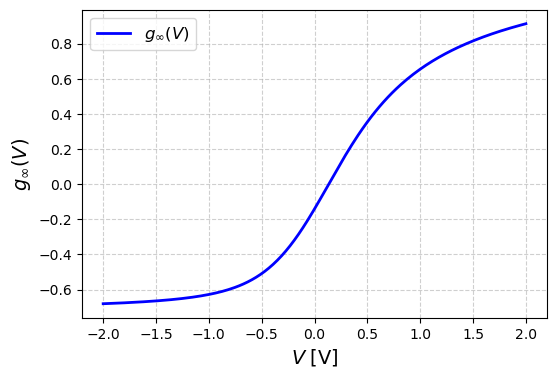

In [3]:
lookup_table = ginf_activator.get_lookup_table()

plt.figure(figsize=(6, 4))
plt.plot(lookup_table[0], lookup_table[1], label=r"$g_{\infty}(V)$", color="blue", linewidth=2)
plt.xlabel(r"$V \;[\text{V}]$", fontsize=14)
plt.ylabel(r"$g_{\infty}(V)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("output/ginf_activator_plot.pdf")
plt.savefig("output/ginf_activator_plot.png")

## ESN with Mackey-Glass time series

In [123]:
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=10,
    output_dim=1,
    leaking_rate=1,
    step_size=0.1,
    time_scale=1,
    spectral_radius=0.9, #guarantee_ESP could change spectral radius if True
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    weight_seed=35,
    activation=ginf_activator.activate,
    guarantee_ESP=False,
)

1.0196641258744636
0.9000000000000016
This initilization might not have the echo state property


In [60]:
# Generate Mackey-Glass time series
mg_series = MackeyGlassGenerator(tau=15, n=10000, n_samples=5000)

# Normalize data between -1 and 1
mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1

# Create input/output pairs for time series prediction
inputs = mg_series[:-1].reshape(-1, 1)
targets = mg_series[1:].reshape(-1, 1)

# Split into train and test sets
train_len = 4000
test_len = 1000
train_inputs = inputs[:train_len]
train_targets = targets[:train_len]
test_inputs = inputs[train_len : train_len + test_len]
test_targets = targets[train_len : train_len + test_len]

In [61]:
washout=100

# Train on first part of series
esn.fit(train_inputs, train_targets, washout=washout)

# Generate predictions on test set
predictions = esn.predict(test_inputs)

In [62]:
# Calculate prediction error after network settled from np.zeroes initialization
print(f"Test MSE: {mse(test_targets, predictions)}")

Test MSE: 0.0037339006246713533


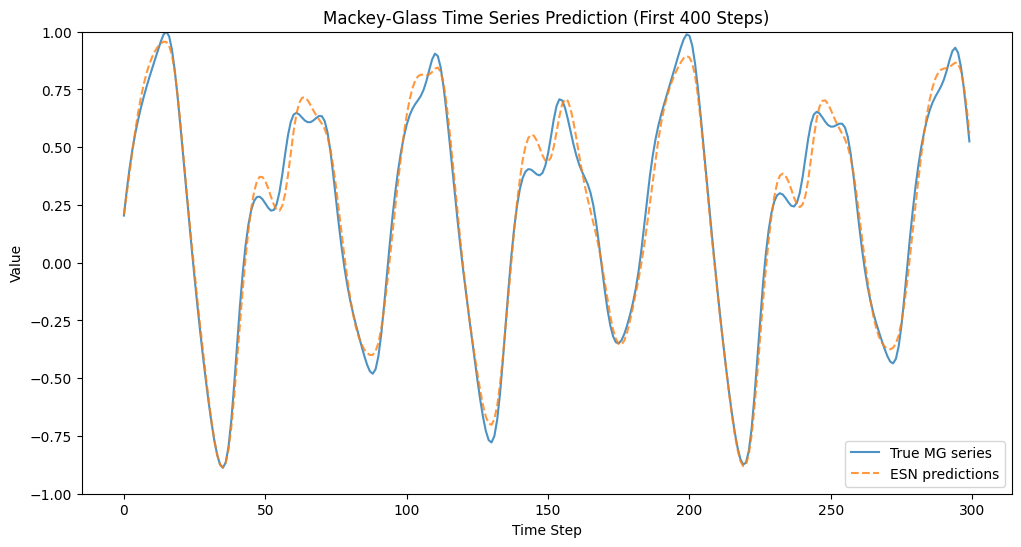

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(test_targets[washout:400], label="True MG series", alpha=0.8)
plt.plot(predictions[washout:400], label="ESN predictions", linestyle="--", alpha=0.8)
plt.title("Mackey-Glass Time Series Prediction (First 400 Steps)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.ylim(-1,1)
plt.legend()
plt.savefig("output/mg_prediction_plot.pdf")
plt.savefig("output/mg_prediction_plot.png")

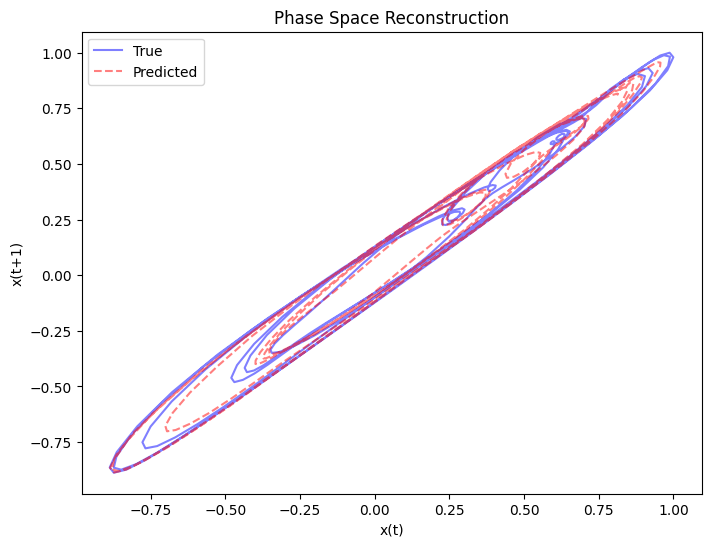

In [64]:
# Plot phase space reconstruction
plt.figure(figsize=(8, 6))
plt.plot(test_targets[:-1][washout:400], test_targets[1:][washout:400], "b-", alpha=0.5, label="True")
plt.plot(predictions[:-1][washout:400], predictions[1:][washout:400], "r--", alpha=0.5, label="Predicted")
plt.title("Phase Space Reconstruction")
plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.legend()
plt.savefig("output/mg_phase_space_plot.pdf")
plt.savefig("output/mg_phase_space_plot.png")

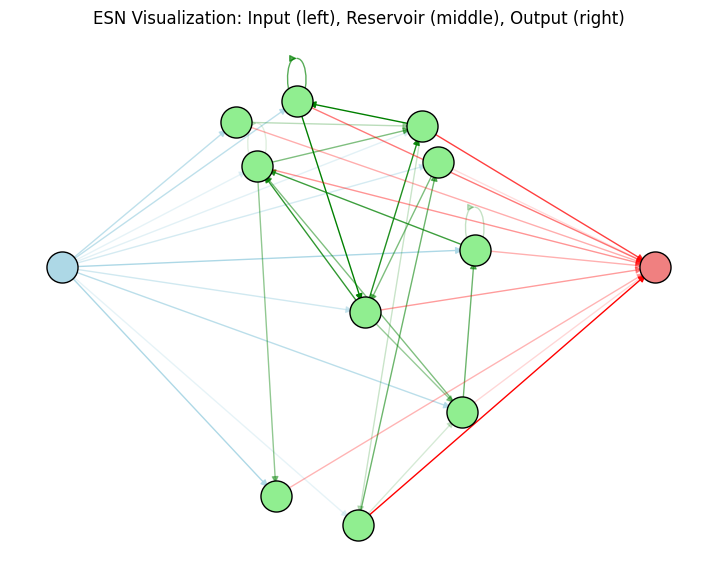

In [65]:
esn.visualize_reservoir()

## ESN with Harmonic Wave time series

In [66]:
# Initialize and train ESN
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=10,
    output_dim=1,
    leaking_rate=1,
    step_size=0.3,
    time_scale=1,
    spectral_radius=0.95,
    sparsity=0.7,
    input_scaling=1.0,
    regularization=1e-4,
    activation=np.tanh,
)

In [67]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 6 * np.pi, 1000)
data = np.sin(t) * np.cos(t) * t

# Create input/output pairs for time series prediction
inputs = data[:-1].reshape(-1, 1)
targets = data[1:].reshape(-1, 1)

In [68]:
# Train on synthetic data
esn.fit(inputs, targets, washout=100)

# Generate predictions
predictions = esn.predict(inputs)

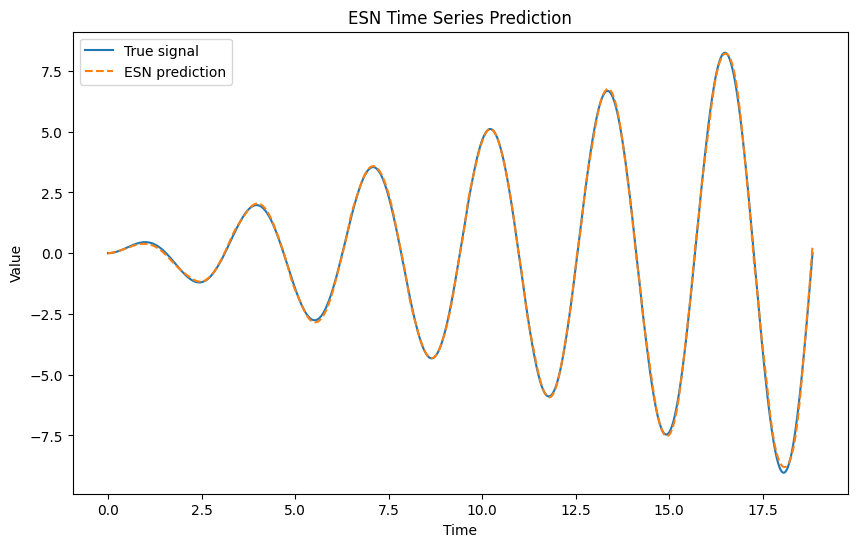

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(t[:-1], targets, label="True signal")
plt.plot(t[:-1], predictions, label="ESN prediction", linestyle="--")
plt.title("ESN Time Series Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("output/sine_prediction_plot.pdf")
plt.savefig("output/sine_prediction_plot.png")

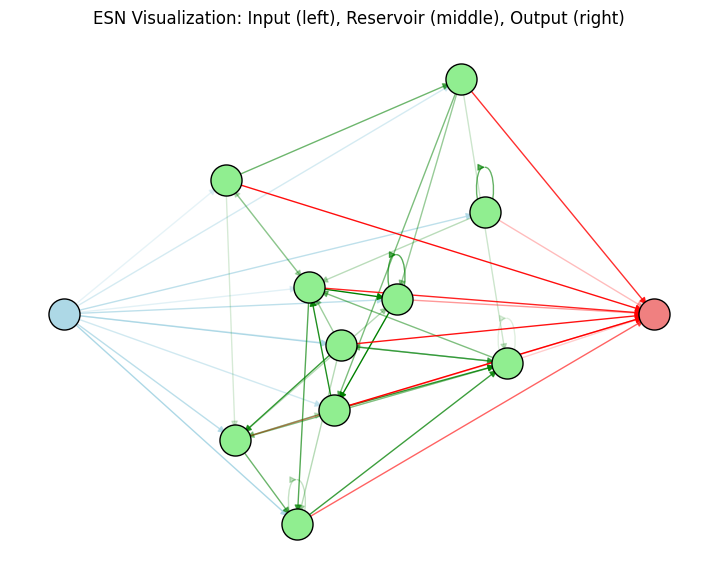

In [70]:
esn.visualize_reservoir()